## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-13 16:16:12.820657


{1: 24.4,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.8,
 50: 31.6,
 60: 33.3,
 70: 35.2,
 80: 37.5,
 90: 41.0,
 95: 43.8,
 99: 49.4}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-06-14 13:17:02.014756


{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.5,
 30: 8.7,
 40: 8.7,
 50: 8.8,
 60: 8.9,
 70: 9.1,
 80: 9.2,
 90: 9.4,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-13 23:05:32.824387


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev1),
 'tai_flop_size': array([36.1, 34.8, 42.7, ..., 28.1, 31.4, 45.4]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.64, lognorm_sd=0.72, norm_mean=0.41, norm_sd=0.42) (version 0.28-dev1),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev1),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev1),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 19763.63it/s]


{1: 0.00147,
 5: 0.00208,
 10: 0.00245,
 20: 0.00309,
 30: 0.00364,
 40: 0.00419,
 50: 0.00477,
 60: 0.00552,
 70: 0.00656,
 80: 0.0082,
 90: 0.01322,
 95: 0.02321,
 99: 0.04196}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.147%',
 5: '0.208%',
 10: '0.245%',
 20: '0.309%',
 30: '0.364%',
 40: '0.419%',
 50: '0.477%',
 60: '0.552%',
 70: '0.656%',
 80: '0.82%',
 90: '1.322%',
 95: '2.321%',
 99: '4.196%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '37.0 billion',
 5: '52.2 billion',
 10: '61.6 billion',
 20: '77.6 billion',
 30: '91.5 billion',
 40: '105.1 billion',
 50: '119.8 billion',
 60: '138.8 billion',
 70: '164.9 billion',
 80: '206.1 billion',
 90: '331.4 billion',
 95: '582.0 billion',
 99: '1.0 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5973.46it/s]


{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.038%',
 60: '0.054%',
 70: '0.081%',
 80: '0.134%',
 90: '0.265%',
 95: '0.43%',
 99: '1.053%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.038%',
 60: '0.054%',
 70: '0.081%',
 80: '0.134%',
 90: '0.265%',
 95: '0.43%',
 99: '1.053%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '329.9 million',
 5: '889.3 million',
 10: '1.5 billion',
 20: '2.8 billion',
 30: '4.5 billion',
 40: '6.6 billion',
 50: '9.5 billion',
 60: '13.5 billion',
 70: '20.4 billion',
 80: '33.7 billion',
 90: '66.1 billion',
 95: '107.9 billion',
 99: '264.5 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3674.21it/s]


{1: 0.4,
 5: 0.9,
 10: 1.6,
 20: 3.5,
 30: 5.7,
 40: 8.9,
 50: 13.5,
 60: 20.6,
 70: 31.5,
 80: 54.2,
 90: 114.0,
 95: 207.8,
 99: 630.1}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7.7 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~302.8 million).
* This doubles every 0.6 year to a max of 0.028259% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.5 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 26.8 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling issue did not occur
-- data p_nonscaling_issue 

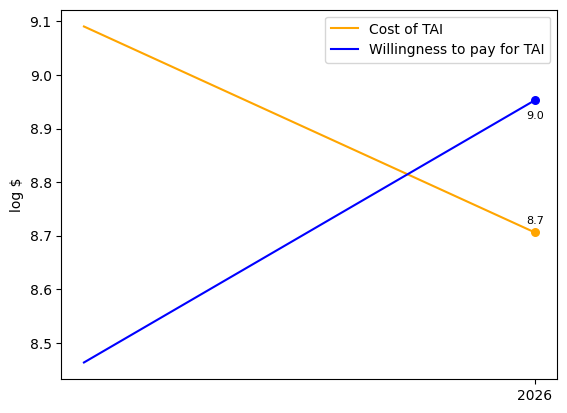



## SAMPLE RUN 2 ##

In this simulation:
* It takes 32.5 log FLOP (~316.2 nonillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.5 log FLOP (~33.9 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~2.9 billion).
* This doubles every 0.9 year to a max of 0.117265% of GDP (initially ~29.3 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 32.5 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 31.9 logFLOP which costs 13.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 10.0 (buys 28.8 log FLOP or 29.9 2025-log-eFLOP)
2028 - TAI takes 30.9 logFLOP which costs 11

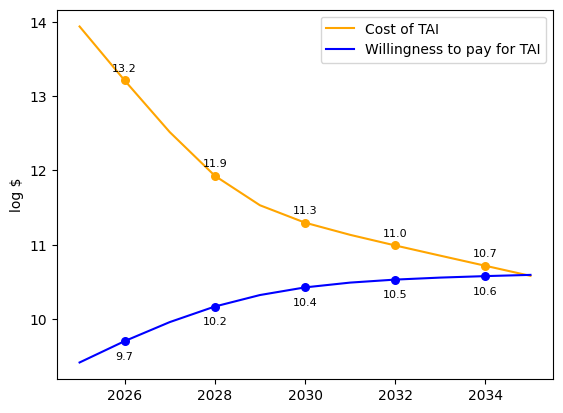



## SAMPLE RUN 3 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~312.1 million).
* This doubles every 0.3 year to a max of 0.095345% of GDP (initially ~23.8 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.5 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 8 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur

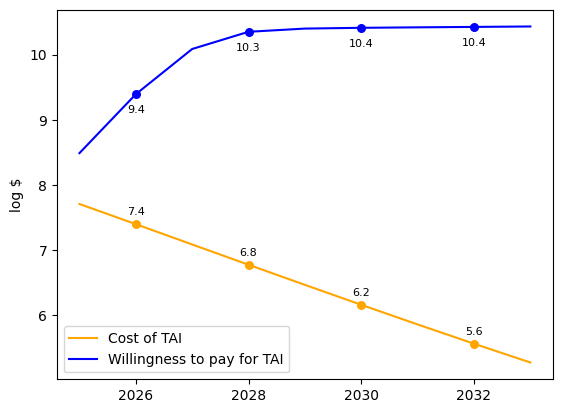



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:11, 840.49it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1297.14it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2026',
 '2%: 2027',
 '3%: 2028',
 '4%: 2028',
 '5%: 2029',
 '10%: 2030',
 '15%: 2031',
 '20%: 2032',
 '25%: 2033',
 '35%: 2036',
 '50%: 2042',
 '60%: 2049',
 '75%: 2071',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 1 years from now',
 '2%: 2 years from now',
 '3%: 3 years from now',
 '4%: 3 years from now',
 '5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 11 years from now',
 '50%: 17 years from now',
 '60%: 24 years from now',
 '75%: 46 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 35 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.1%
2027-2029: 6.6%
2030-2034: 23.5%
2035-2039: 



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.3 trillion) - 13.4 (~27.4 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.7 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.5 trillion) - 13.5 (~31.6 trillion)
Year: 2034 - GDP log 2024$USD 13.

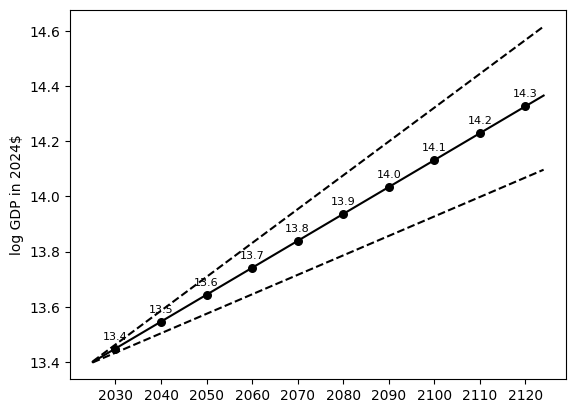

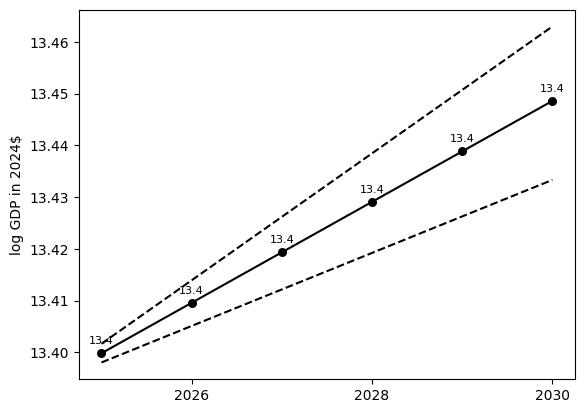



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.3 (~18.4 billion) 80% CI 9.5 (~3.5 billion) - 11.2 (~150.2 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.5 (~34.7 billion) 80% CI 9.9 (~8.0 billion) - 11.4 (~236.9 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.8 (~61.9 billion) 80% CI 10.2 (~15.0 billion) - 11.6 (~367.1 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.0 (~101.5 billion) 80% CI 10.3 (~22.3 billion) - 11.7 (~554.7 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.2 (~149.3 billion) 80% CI 10.4 (~27.4 billion) - 11.9 (~810.2 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~196.0 billion) 80% CI 10.5 (~30.2 billion) - 12.1 (~1.1 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure 

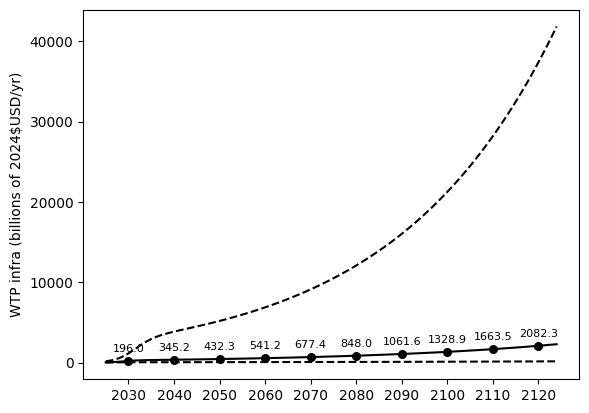

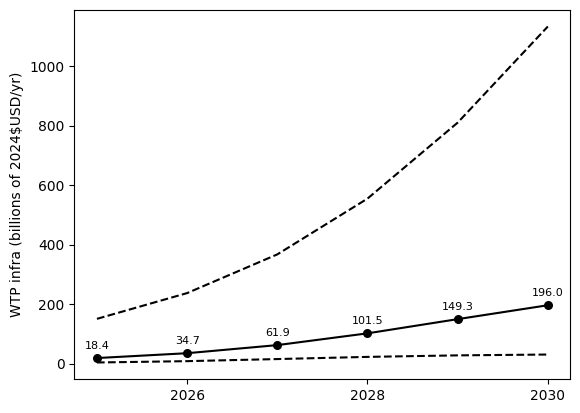



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 8.9 (~735.1 million) 80% CI 8.5 (~350.5 million) - 9.3 (~1.9 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.1 (~1.4 billion) 80% CI 8.9 (~796.2 million) - 9.5 (~3.0 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.4 (~2.5 billion) 80% CI 9.2 (~1.5 billion) - 9.7 (~4.6 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.6 (~4.1 billion) 80% CI 9.3 (~2.2 billion) - 9.8 (~6.9 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.8 (~6.0 billion) 80% CI 9.4 (~2.7 billion) - 10.0 (~10.1 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~7.8 billion) 80% CI 9.5 (~3.0 billion) - 10.2 (~14.2 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~9.4 billion) 80% CI 9.5

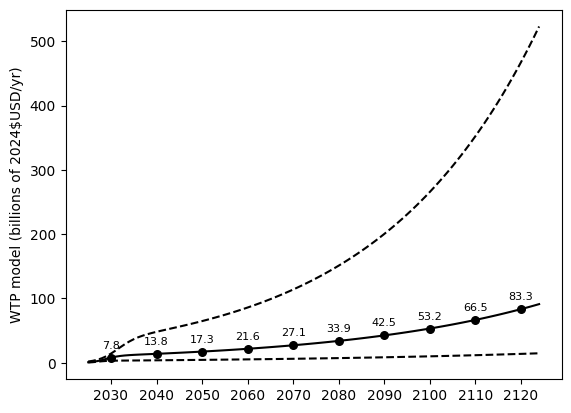

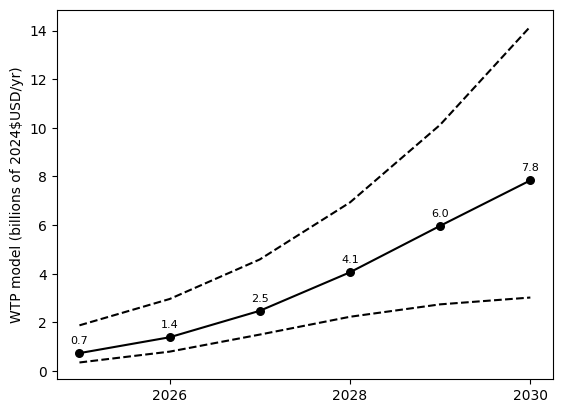



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.7 (~50.1 nonillion) 80% CI 27.1 (~1.3 octillion) - 37.6 (~39.8 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.4 (~25.8 nonillion) 80% CI 26.8 (~666.3 septillion) - 37.4 (~24.4 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.1 (~13.2 nonillion) 80% CI 26.5 (~352.1 septillion) - 37.2 (~14.9 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.8 (~6.9 nonillion) 80% CI 26.3 (~188.9 septillion) - 37.0 (~9.1 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.6 (~3.7 nonillion) 80% CI 26.0 (~104.1 septillion) - 36.7 (~5.6 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.3 (~2.1 nonillion) 80% CI 25.8 (~60.1 septillion) - 36.5 (~3.4 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.1 (~1.3 nonillion) 80% CI 25.6 (~37.3 septillion) - 36.3 (~2.1 thousand decillion)
Year: 2032 - logFLOP needed for TAI 30.0 (~917.0 octillion) 80% CI 25.

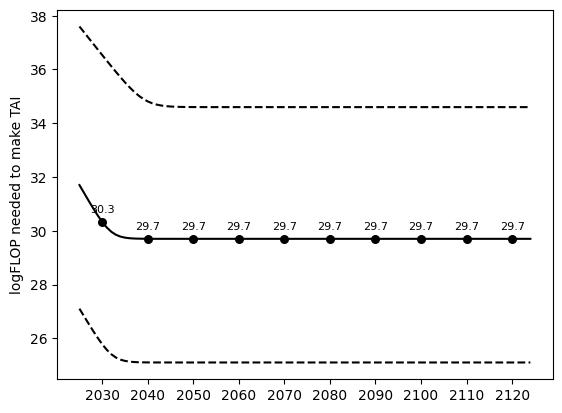

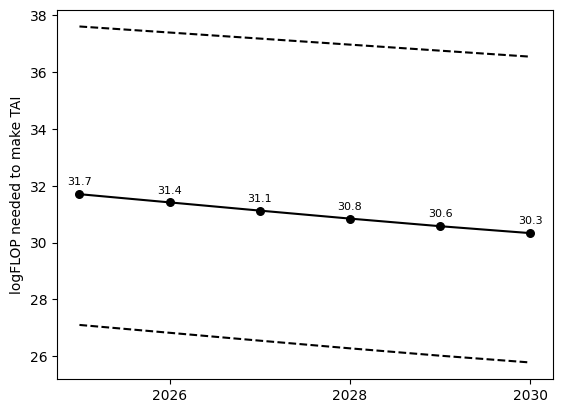



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~1.9 quintillion) 80% CI 17.9 (~780.1 quadrillion) - 18.7 (~5.1 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.5 quintillion) 80% CI 18.0 (~1.1 quintillion) - 18.8 (~6.6 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.5 (~3.3 quintillion) 80% CI 18.2 (~1.5 quintillion) - 18.9 (~8.5 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.6 (~4.4 quintillion) 80% CI 18.3 (~2.0 quintillion) - 19.0 (~11.0 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~5.8 quintillion) 80% CI 18.4 (~2.7 quintillion) - 19.2 (~14.1 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~7.7 quintillion) 80% CI 18.6 (~3.7 quintillion) - 19.3 (~18.2 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.2 quintillion) 80% CI 18.7 (~5.0 quintillion) - 19.4 (~23.4 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.1 (~13.4 quintillion) 80% CI 18.8 (~6.8 quintillion) - 19.5 (~30.1 quintillion)
Year: 2033 - lo

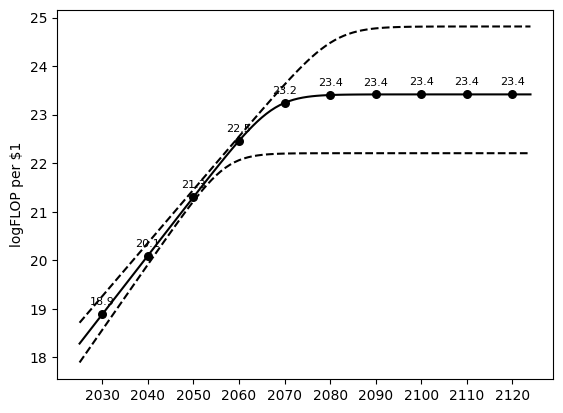

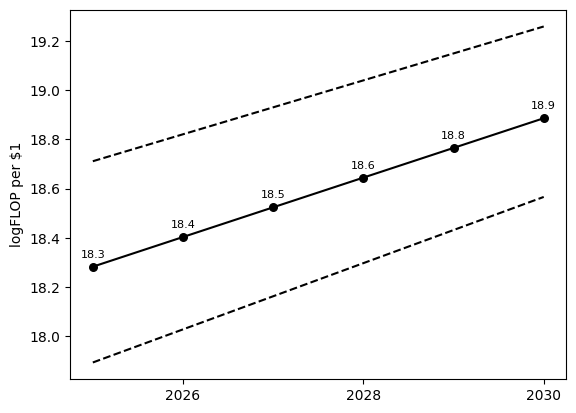



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

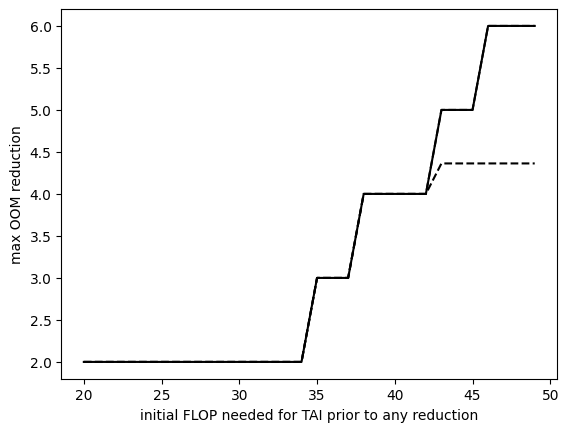



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 21 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 22 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 23 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 24 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 25 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 26 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 27 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 28 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 29 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 30 -> algo doubling rate 1.51yrs (80% CI: 2.09 to 2.09)
TAI log FLOP 31 -> algo doubling rate 1.01yrs (80% CI: 1.59 to 1.59)
TAI log FLOP 32 -> algo doubling rate 1.01yrs (80% CI: 1.09 to 1.09)
TAI log FLOP 33 -> algo doubling rate 1.01yrs (80%

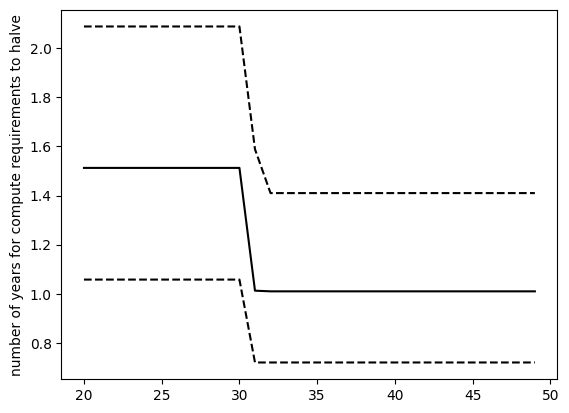



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.4 log 2024$USD to buy TAI (~26.2 trillion) 80% CI 9.2 (~1.6 billion) - 18.9 (~7.7 quintillion)
Year: 2026 - 13.0 log 2024$USD to buy TAI (~10.2 trillion) 80% CI 8.8 (~626.3 million) - 18.6 (~3.7 quintillion)
Year: 2027 - 12.6 log 2024$USD to buy TAI (~4.0 trillion) 80% CI 8.4 (~242.6 million) - 18.2 (~1.8 quintillion)
Year: 2028 - 12.2 log 2024$USD to buy TAI (~1.6 trillion) 80% CI 8.0 (~95.4 million) - 17.9 (~833.8 quadrillion)
Year: 2029 - 11.8 log 2024$USD to buy TAI (~642.4 billion) 80% CI 7.6 (~38.6 million) - 17.6 (~397.3 quadrillion)
Year: 2030 - 11.4 log 2024$USD to buy TAI (~277.6 billion) 80% CI 7.2 (~16.3 million) - 17.3 (~189.6 quadrillion)
Year: 2031 - 11.1 log 2024$USD to buy TAI (~130.4 billion) 80% CI 6.9 (~7.4 million) - 17.0 (~90.7 quadrillion)
Year: 2032 - 10.8 log 2024$USD to buy TAI (~68.3 billion) 80% CI 6.6 (~3.7 million) - 16.6 (~43.6 quadrillion)
Year: 20

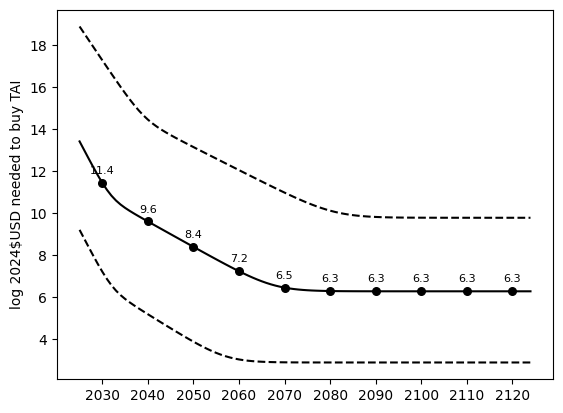

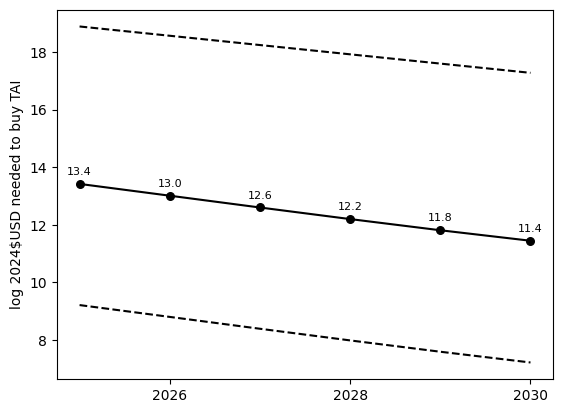



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.1 (~1.4 octillion) 80% CI 26.4 (~273.4 septillion) - 28.0 (~9.7 octillion)
Year: 2026 - max log FLOP 27.5 (~3.5 octillion) 80% CI 26.9 (~847.1 septillion) - 28.3 (~19.6 octillion)
Year: 2027 - max log FLOP 27.9 (~8.3 octillion) 80% CI 27.3 (~2.2 octillion) - 28.6 (~39.1 octillion)
Year: 2028 - max log FLOP 28.3 (~17.9 octillion) 80% CI 27.6 (~4.4 octillion) - 28.9 (~76.1 octillion)
Year: 2029 - max log FLOP 28.5 (~34.8 octillion) 80% CI 27.9 (~7.4 octillion) - 29.2 (~143.1 octillion)
Year: 2030 - max log FLOP 28.8 (~60.3 octillion) 80% CI 28.0 (~11.1 octillion) - 29.4 (~257.7 octillion)
Year: 2031 - max log FLOP 29.0 (~95.2 octillion) 80% CI 28.2 (~15.9 octillion) - 29.6 (~441.5 octillion)
Year: 2032 - max log FLOP 29.1 (~140.4 octillion) 80% CI 28.3 (~22.3 octillion) - 29.9 (~717.6 octillion)
Year: 2033 - max log FLOP 29.3 (~198.9 octillion) 80% CI 28.5 (~31.1 octillion) - 30.0 (~1.1 nonillion)
Year: 2034 - max log FLOP 29.

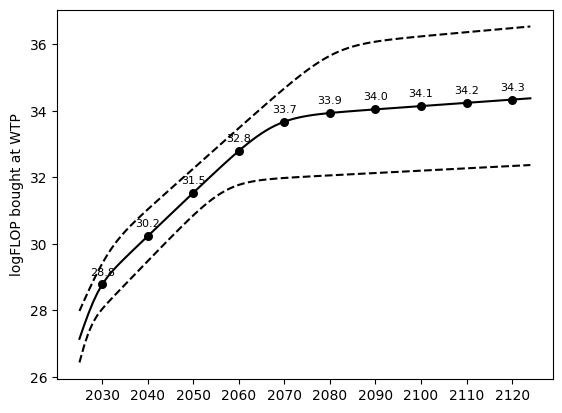

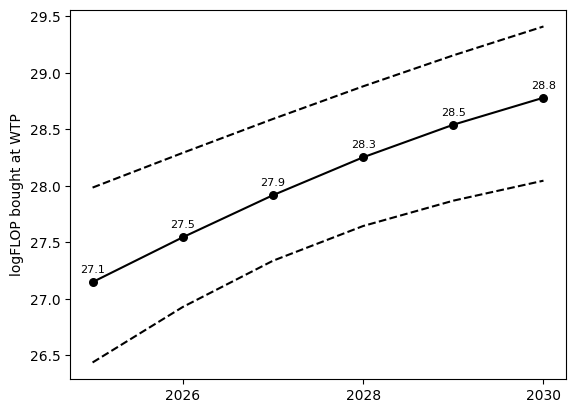



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.1 (~1.4 octillion) 80% CI 26.4 (~273.4 septillion) - 28.0 (~9.7 octillion)
Year: 2026 - max log effective 2024-FLOP 27.8 (~6.8 octillion) 80% CI 27.1 (~1.4 octillion) - 28.7 (~51.2 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~31.3 octillion) 80% CI 27.8 (~5.7 octillion) - 29.4 (~266.3 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~129.6 octillion) 80% CI 28.3 (~18.5 octillion) - 30.1 (~1.3 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.7 (~465.9 octillion) 80% CI 28.7 (~49.3 octillion) - 30.8 (~6.4 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.4 nonillion) 80% CI 29.1 (~116.3 octillion) - 31.5 (~28.2 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.6 nonillion) 80% CI 29.4 (~255.3 octillion) - 32.0 (~107.6 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~7.7 nonillion) 80% CI 29.7 (

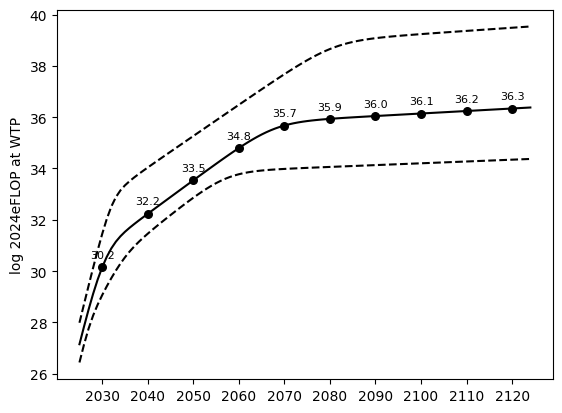

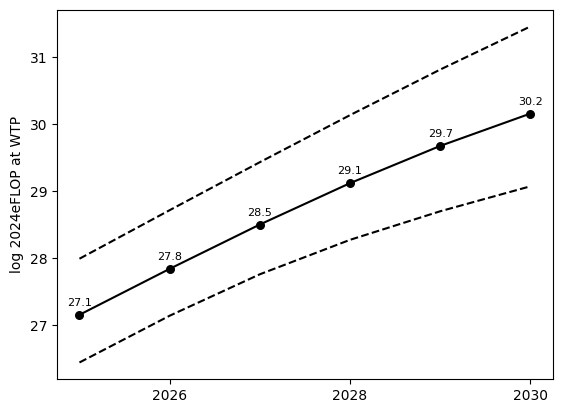


## TAI FLOP SIZE ##
{1: 24.5,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.9,
 50: 31.7,
 60: 33.44,
 70: 35.4,
 80: 37.6,
 90: 40.8,
 95: 43.504999999999995,
 99: 49.101}


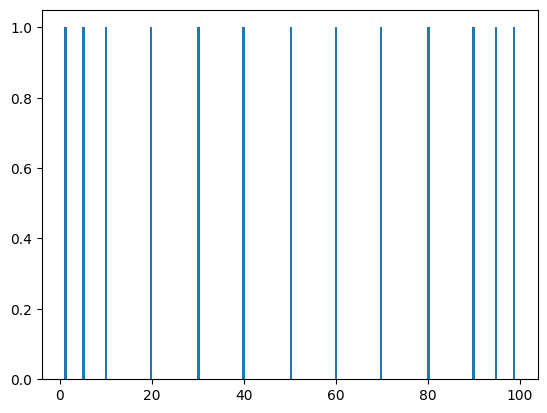



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.280138810441266,
 5: 3.1183183950341005,
 10: 3.539413776519476,
 20: 4.362999391684326,
 30: 5.099416173734329,
 40: 5.720785940561253,
 50: 6.539983550116595,
 60: 7.491557789642948,
 70: 8.639995764630118,
 80: 9.91406001008385,
 90: 12.639731686704756,
 95: 15.019009213739977,
 99: 20.3470208541291}


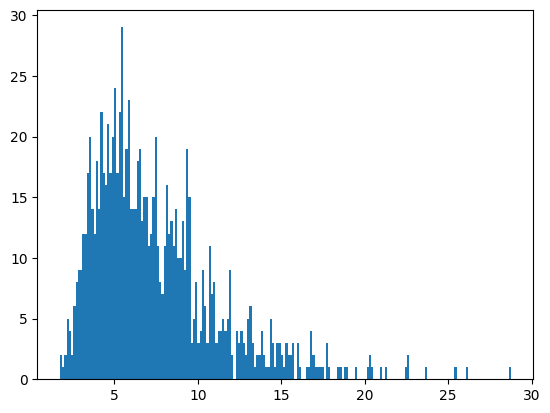



## MIN ALGO DOUBLING RATE ##
{1: 0.37481784400684687,
 5: 0.5193914605590914,
 10: 0.6055094202528328,
 20: 0.7201716108076047,
 30: 0.8162558771725467,
 40: 0.9081524616571591,
 50: 1.0098632837475252,
 60: 1.1186017730691402,
 70: 1.2568633272374374,
 80: 1.409958148675223,
 90: 1.7416181815897642,
 95: 2.026551613760855,
 99: 2.616255685051955}


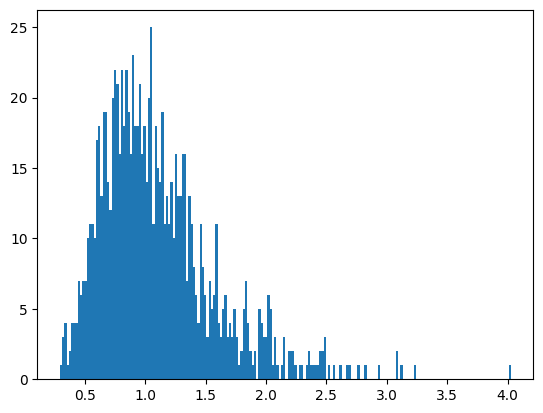



## MAX ALGO DOUBLING RATE ##
{1: 0.545013139356273,
 5: 0.7797560322734044,
 10: 0.8885785372118179,
 20: 1.0577407553111855,
 30: 1.210963870694223,
 40: 1.3635145806225208,
 50: 1.512546561279069,
 60: 1.6742325660406896,
 70: 1.855907124762846,
 80: 2.0884590583188265,
 90: 2.532195068830914,
 95: 2.9204690471045702,
 99: 3.879717466079473}


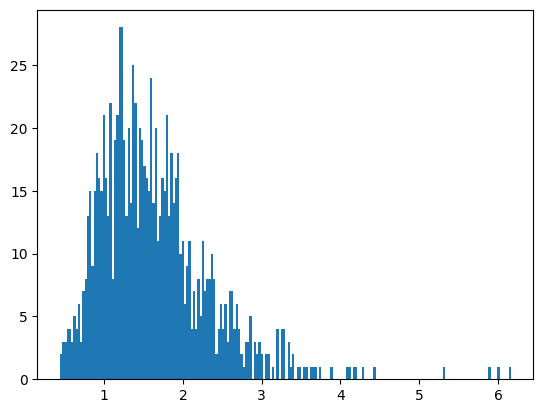



## INITIAL FLOP PER DOLLAR ##
{1: 17.251875928156366,
 5: 17.545991555149662,
 10: 17.705046599451933,
 20: 17.89217350456919,
 30: 18.03399990961432,
 40: 18.175206504815982,
 50: 18.28200897559629,
 60: 18.407480806830797,
 70: 18.558028155968437,
 80: 18.711262020083282,
 90: 18.900622614670088,
 95: 19.08048874512299,
 99: 19.381522492974433}


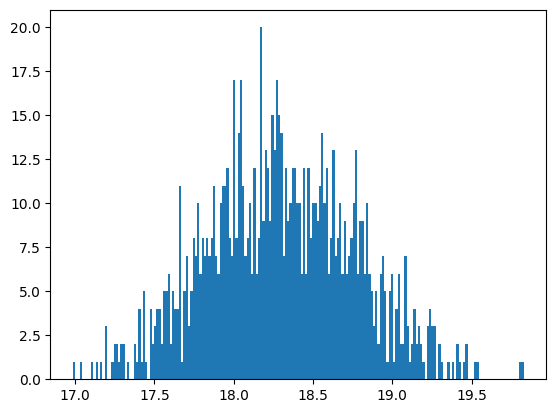



## FLOP HALVING RATE ##
{1: 1.8214673303052686,
 5: 1.9821657518309268,
 10: 2.0825334941802507,
 20: 2.233613897088487,
 30: 2.347590462388085,
 40: 2.416757492468262,
 50: 2.490790752037942,
 60: 2.58177641505135,
 70: 2.663218583511138,
 80: 2.7444065910594015,
 90: 2.8991026101779207,
 95: 3.014265300521917,
 99: 3.2822717622991253}


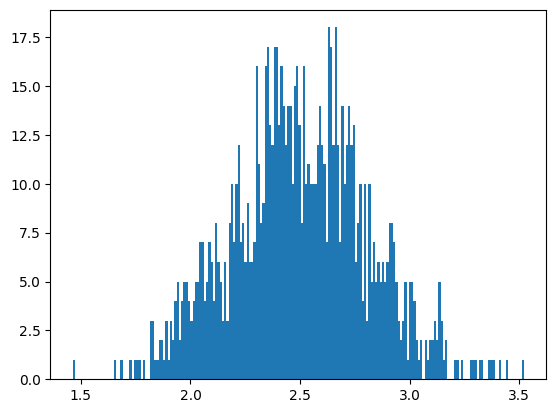



## MAX FLOP PER DOLLAR ##
{1: 20.195082910940904,
 5: 20.98740483823367,
 10: 21.575062987144204,
 20: 22.205178475392998,
 30: 22.660907637996218,
 40: 23.07753822174687,
 50: 23.41716847113863,
 60: 23.82072230851113,
 70: 24.247226544372168,
 80: 24.816987351050248,
 90: 25.497270363453858,
 95: 26.027714931925246,
 99: 26.958605204202897}


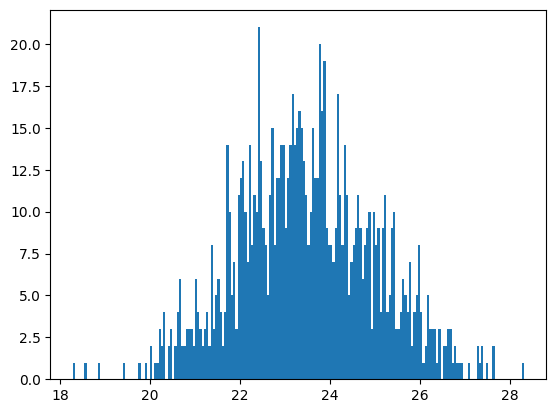



## INITIAL PAY ##
{1: 8.2,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.5,
 95: 9.6,
 99: 10.1}


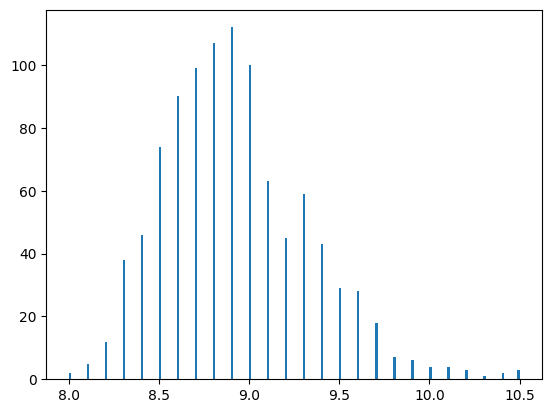



## INITIAL GDP ##
{1: 24804201344391.094,
 5: 24895256257230.32,
 10: 24945735188426.895,
 20: 25005303958669.81,
 30: 25039929572625.95,
 40: 25074913964768.543,
 50: 25107840841253.29,
 60: 25144621576551.49,
 70: 25178197784385.582,
 80: 25214385039955.832,
 90: 25280853114376.508,
 95: 25319677393271.152,
 99: 25414634830644.168}


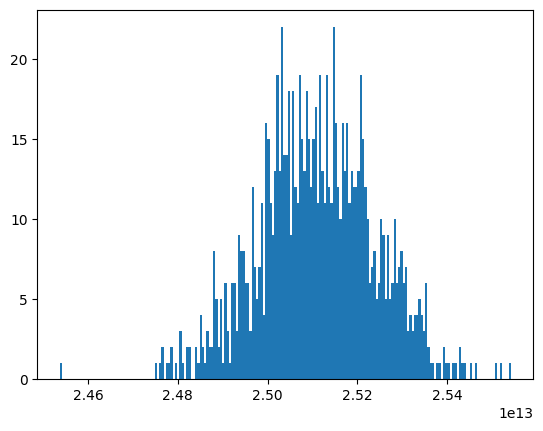



## GDP GROWTH ##
{1: 1.0058755292851358,
 5: 1.0107685063276546,
 10: 1.013308052536081,
 20: 1.0163799326292646,
 30: 1.0186401077520766,
 40: 1.020643819787718,
 50: 1.0227120321629783,
 60: 1.0248008537525999,
 70: 1.0263846900373832,
 80: 1.0286394599570512,
 90: 1.031964485526305,
 95: 1.035359583825143,
 99: 1.0403043756120158}


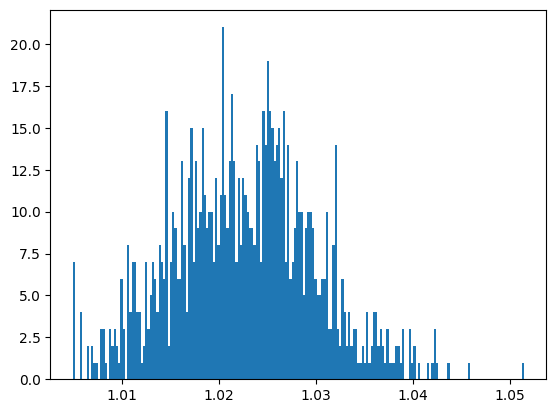



## MAX GDP FRAC ##
{1: 1.2300655308817504e-05,
 5: 3.629532054571539e-05,
 10: 5.845888925892209e-05,
 20: 0.00011729972877557286,
 30: 0.00018897627614427782,
 40: 0.00029134018544738207,
 50: 0.0003928493294039527,
 60: 0.0005601717818395313,
 70: 0.0007886398959986221,
 80: 0.0012669834181864878,
 90: 0.0025733859646804814,
 95: 0.004023846875724738,
 99: 0.011679957542427996}


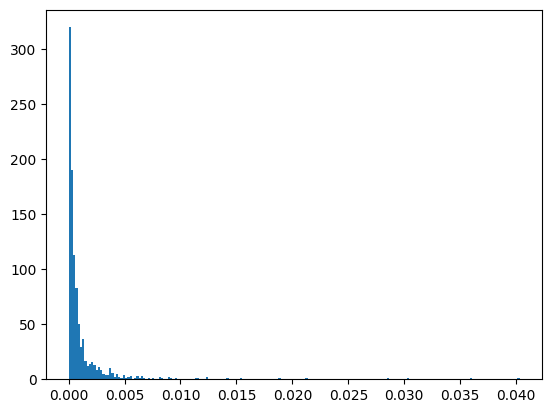



## SPEND DOUBLING TIME ##
{1: 0.3915350379124869,
 5: 0.4960658488408679,
 10: 0.5902479448960007,
 20: 0.690532176115766,
 30: 0.787412574241863,
 40: 0.8805549256775393,
 50: 0.9820451341404404,
 60: 1.1098880258665629,
 70: 1.2216674959024132,
 80: 1.4164786016080135,
 90: 1.6968563247045354,
 95: 2.0246486359419547,
 99: 2.7195214566812798}


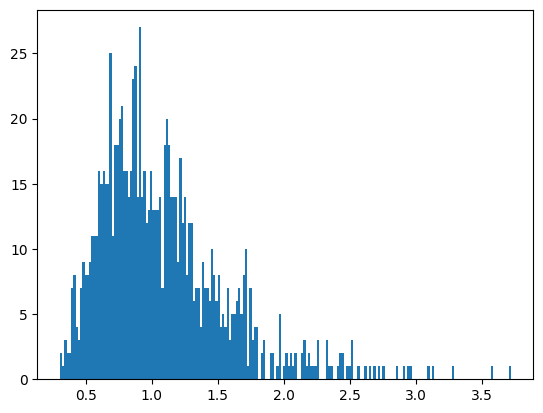





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 1,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 14}
## Chance of nonscaling delay ##


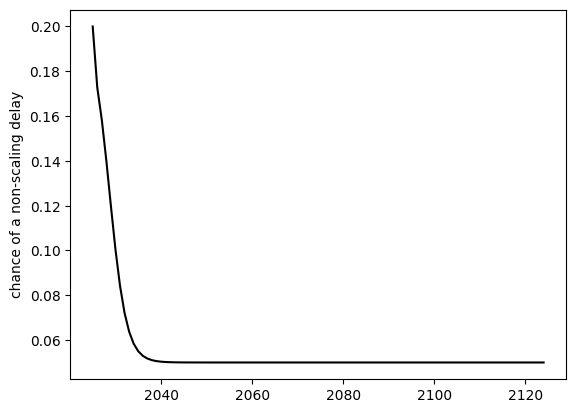

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

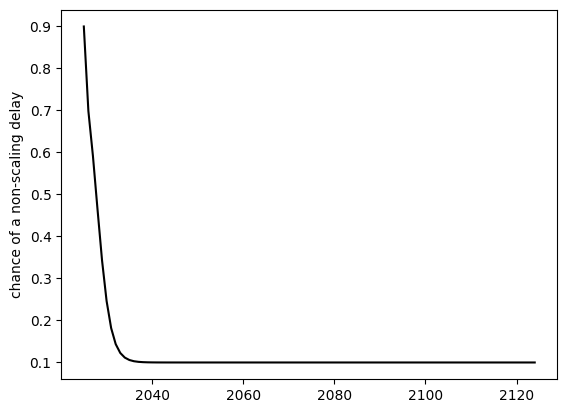

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2035

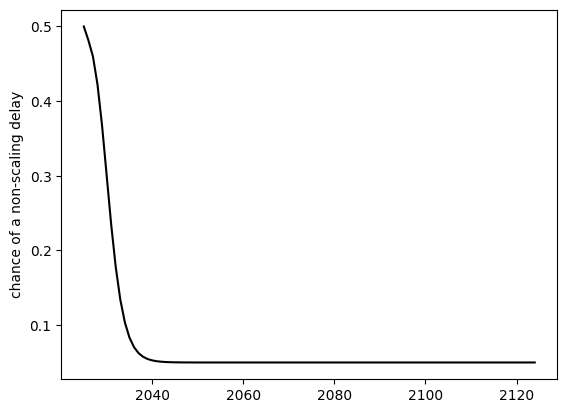

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

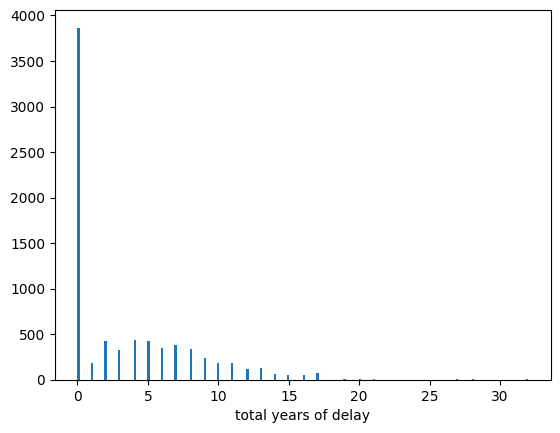

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 41.9 log FLOP (~794.3 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~259.9 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~542.4 million).
* This doubles every 0.6 year to a max of 0.015352% of GDP (initially ~3.9 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 41.9 logFLOP which costs 23.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 41.4 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 40.8 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 40.3 logFLOP whi

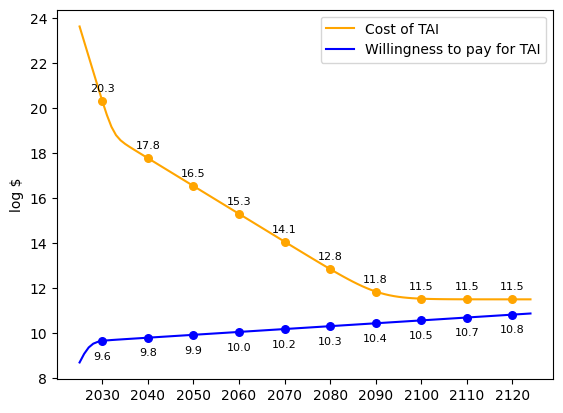

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~3.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~275.6 million).
* This doubles every 0.8 year to a max of 0.008614% of GDP (initially ~2.1 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 27.0 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 11 years (t

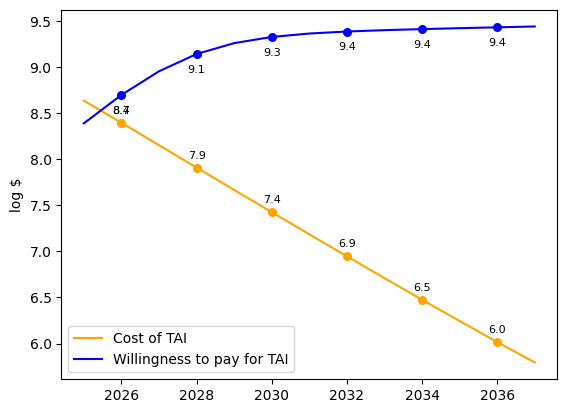

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 25.5 log FLOP (~31.6 septillion) for transformative capabilities.
* Every 4.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~96.4 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~945.7 million).
* This doubles every 1.4 year to a max of 0.069106% of GDP (initially ~17.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 25.5 logFLOP which costs 7.2 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 12 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not oc

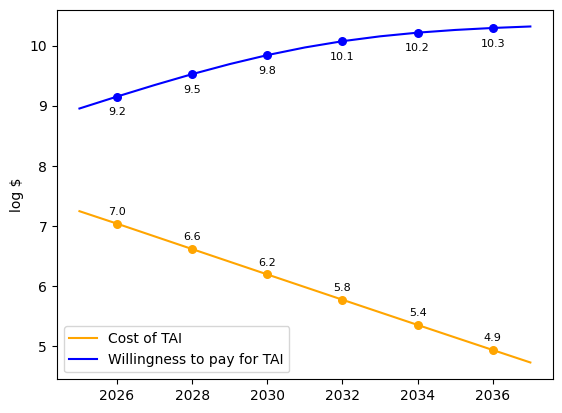

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 32.9 log FLOP (~794.3 nonillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~122.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~658.2 million).
* This doubles every 0.9 year to a max of 0.003542% of GDP (initially ~892.0 million 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 32.9 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.8 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which co

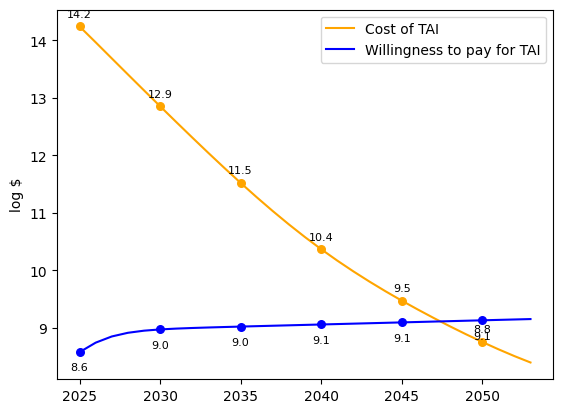

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~299.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~776.2 million).
* This doubles every 1.0 year to a max of 0.135481% of GDP (initially ~33.9 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 25.9 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
/!\ FLOP for TAI sufficient but needs 7 

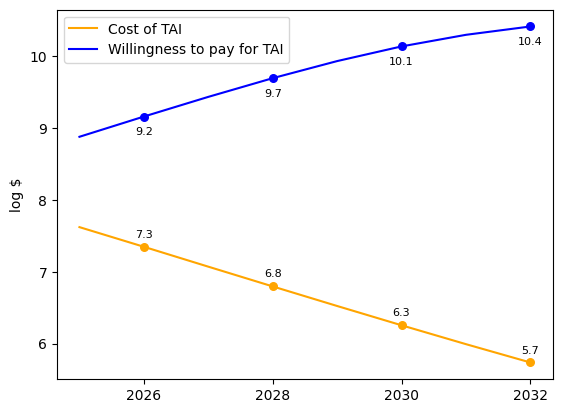

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 41.4 log FLOP (~251.2 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 25.9 log FLOP (~73.7 septillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.6 billion).
* This doubles every 0.7 year to a max of 0.022368% of GDP (initially ~5.6 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 41.4 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 41.0 logFLOP which costs 22.1 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 40.5 logFLOP which costs 21.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.7 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP which

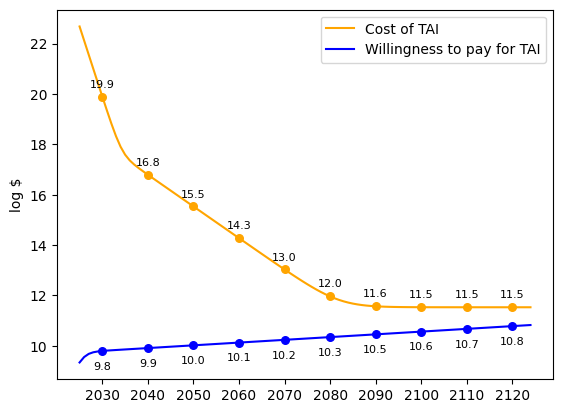

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 35.1 log FLOP (~125.9 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 1.3 year to a max of 0.028371% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 35.1 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 34.9 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 34.7 logFLOP which costs 16.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 34.4 logFLOP which costs 1

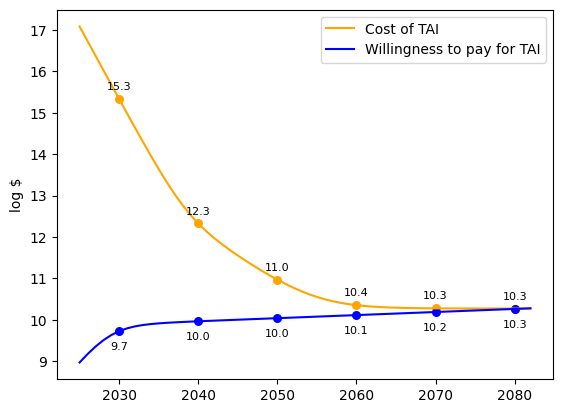

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 35.6 log FLOP (~398.1 decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~612.5 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 26.7 log FLOP (~473.5 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~226.2 million).
* This doubles every 2.3 year to a max of 0.009098% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 35.6 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.3 (buys 26.1 log FLOP or 26.1 2025-log-eFLOP)
2026 - TAI takes 35.4 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.4 (buys 26.3 log FLOP or 26.5 2025-log-eFLOP)
2027 - TAI takes 35.2 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 27.0 2025-log-eFLOP)
2028 - TAI takes 35.0 logFLOP which c

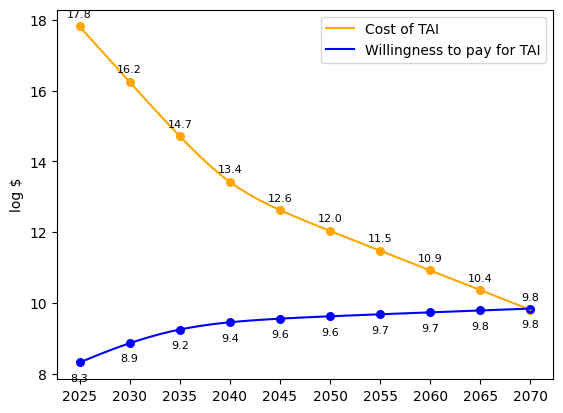

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~24.4 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~740.0 million).
* This doubles every 1.2 year to a max of 0.007156% of GDP (initially ~1.8 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 14.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.7 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 32.5 logFLOP which cost

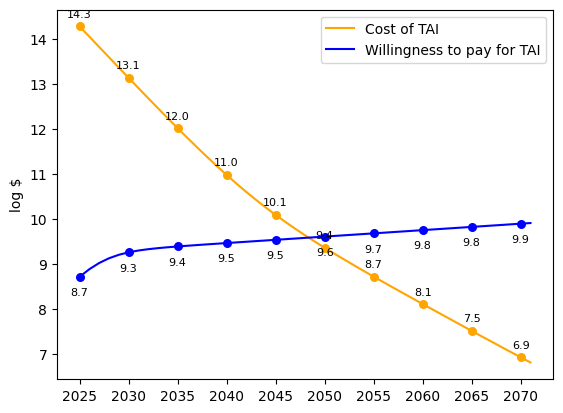

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 33.3 log FLOP (~2.0 decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~247.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~311.5 million).
* This doubles every 1.1 year to a max of 0.002042% of GDP (initially ~512.5 million 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 33.3 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.3 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 32.9 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 8.4 (buys 26.7 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 32.6 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 32.3 logFLOP which cos

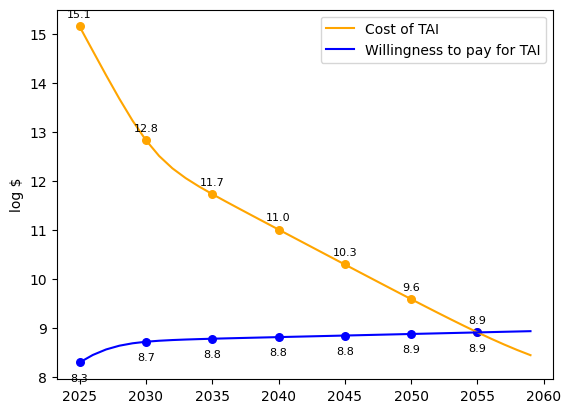

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 38.2 log FLOP (~158.5 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~706.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~396.9 million).
* This doubles every 0.9 year to a max of 0.531023% of GDP (initially ~133.5 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 38.2 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 8.9 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 37.4 logFLOP which costs 18.2 log 2025$USD to buy vs. WTP at 9.3 (buys 28.5 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 37.1 logFLO

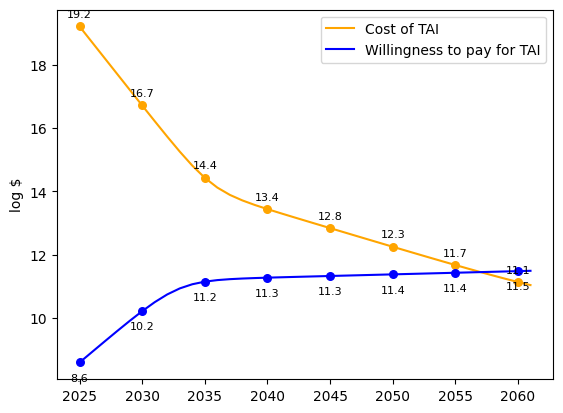

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 25.7 log FLOP (~50.1 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~45.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.7 billion).
* This doubles every 1.1 year to a max of 0.075906% of GDP (initially ~19.0 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 25.7 logFLOP which costs 6.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 11 years (total delay 11 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 12 ye

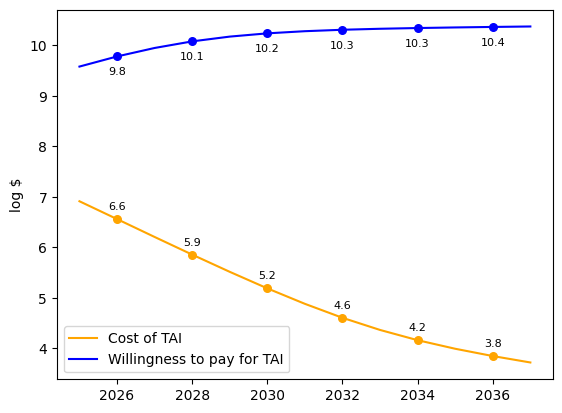

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 29.8 log FLOP (~631.0 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~113.1 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~868.0 million).
* This doubles every 1.6 year to a max of 0.011108% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 29.8 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 29.1 logFLOP which cos

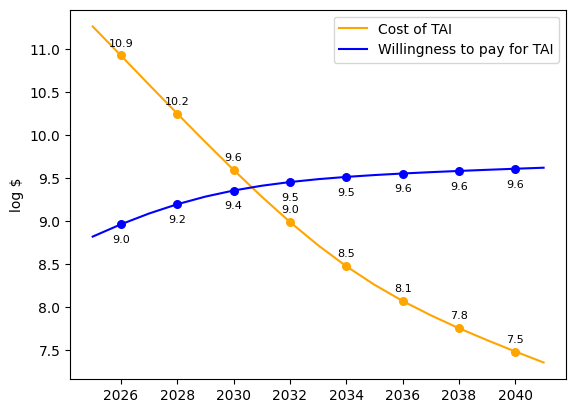

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~284.4 quadrillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.3 year to a max of 0.112218% of GDP (initially ~28.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 9.1 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 9.3 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 33.4 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.5 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 33.2 logFLOP which costs

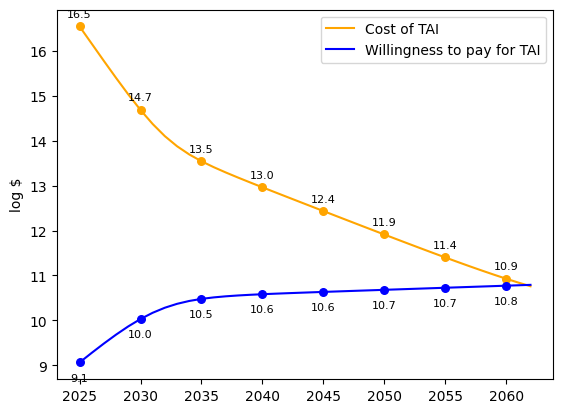

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 28.6 log FLOP (~39.8 octillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.9 quintillion) per 2025$USD.
* Every 1.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.8 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~600.3 million).
* This doubles every 0.9 year to a max of 0.049181% of GDP (initially ~12.4 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 28.6 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling issue did not occur
-- data p_nonscaling_

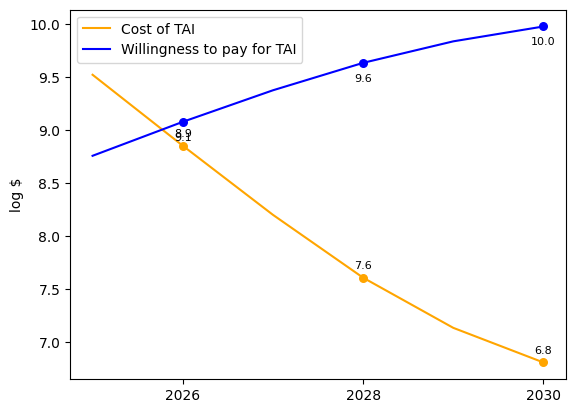

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 36.2 log FLOP (~1.6 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~619.1 quadrillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~397.9 million).
* This doubles every 1.1 year to a max of 2.800587% of GDP (initially ~703.6 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 36.2 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 35.9 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 35.7 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.2 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 35.4 logFLOP 

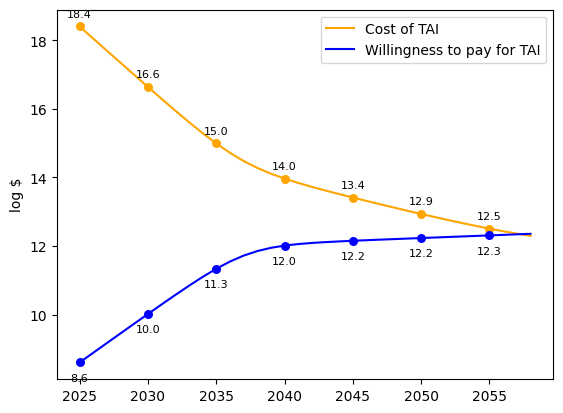

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~47.1 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~480.4 million).
* This doubles every 1.0 year to a max of 0.045971% of GDP (initially ~11.6 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 7.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not o

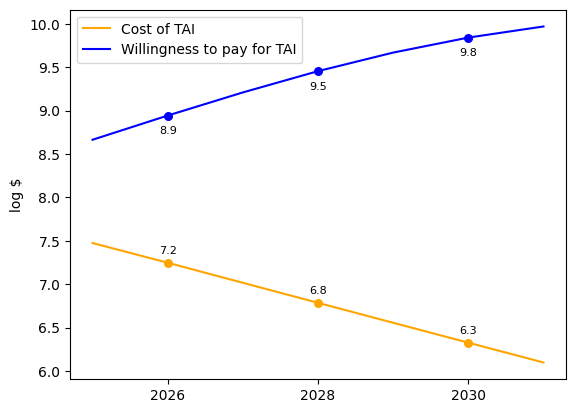

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.5 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~41.5 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 0.6 year to a max of 0.04683% of GDP (initially ~11.8 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 9.9 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which costs 10

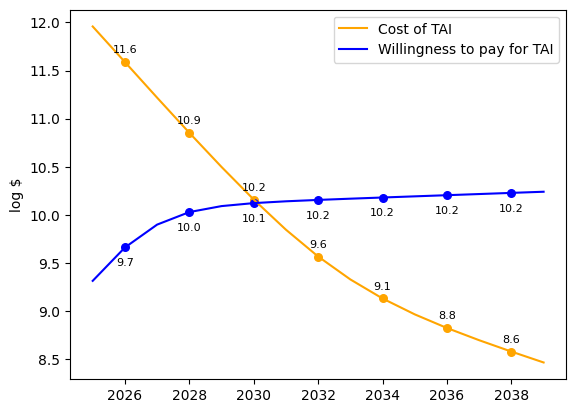

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.1 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~386.1 million).
* This doubles every 1.0 year to a max of 0.050518% of GDP (initially ~12.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 33.5 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 33.3 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 33.1 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which costs 

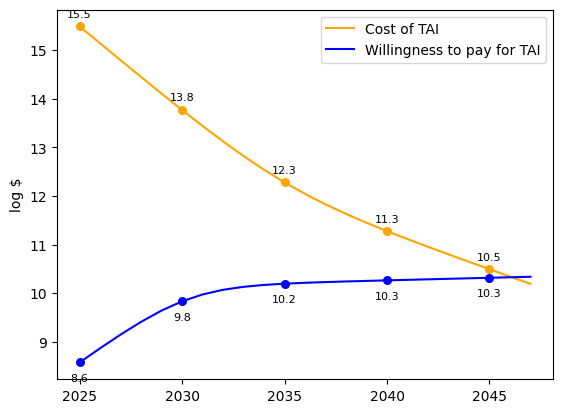

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 25.2 log FLOP (~15.8 septillion) for transformative capabilities.
* Every 3.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~671.2 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.6 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.2 billion).
* This doubles every 0.6 year to a max of 0.036103% of GDP (initially ~9.1 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 25.2 logFLOP which costs 7.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 4 mo

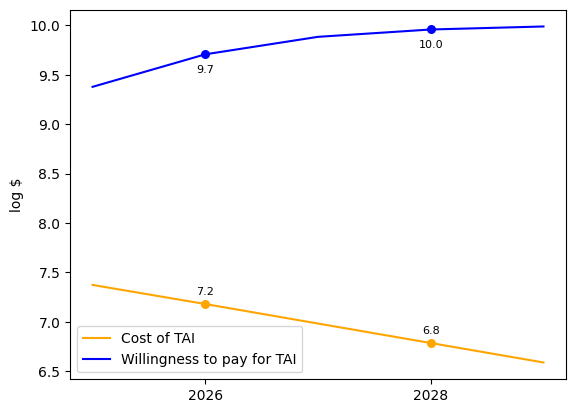

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~89.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~156.9 million).
* This doubles every 0.8 year to a max of 0.06313% of GDP (initially ~15.9 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 24.0 logFLOP which costs 5.6 log 2025$USD to buy vs. WTP at 8.2 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
/!\ FLOP for TAI sufficient but needs 3

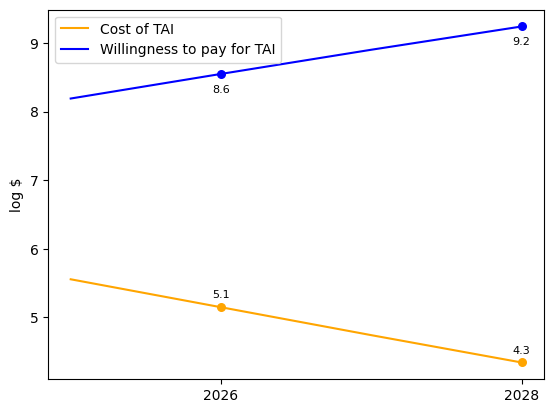

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 40.9 log FLOP (~79.4 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~711.8 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.8 year to a max of 0.221882% of GDP (initially ~55.8 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 40.9 logFLOP which costs 22.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 40.6 logFLOP which costs 22.2 log 2025$USD to buy vs. WTP at 9.5 (buys 27.9 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 40.3 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 9.8 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 39.9 logFLOP wh

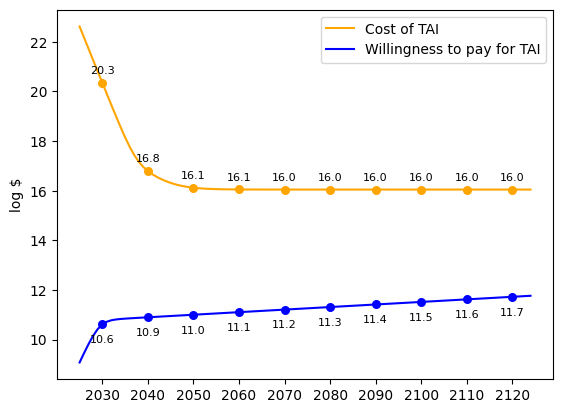

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 31.4 log FLOP (~25.1 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~127.7 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~390.0 million).
* This doubles every 1.0 year to a max of 0.075541% of GDP (initially ~19.1 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 31.4 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.1 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 30.8 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 30.6 logFLOP which cos

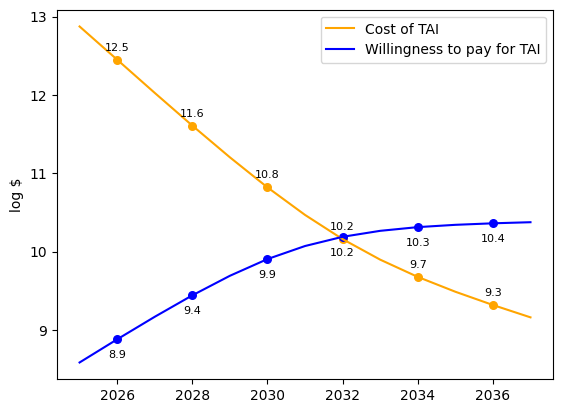

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 37.6 log FLOP (~39.8 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.1 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.4 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 1.1 year to a max of 0.011162% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.05x per year.
---
2025 - TAI takes 37.6 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.0 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 37.0 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 36.4 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP which

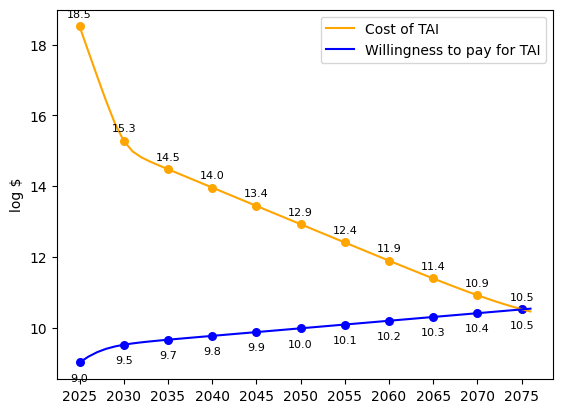

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2.1 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~159.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~313.7 million).
* This doubles every 0.6 year to a max of 0.152273% of GDP (initially ~38.6 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 33.3 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 9.4 (buys 28.3 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which c

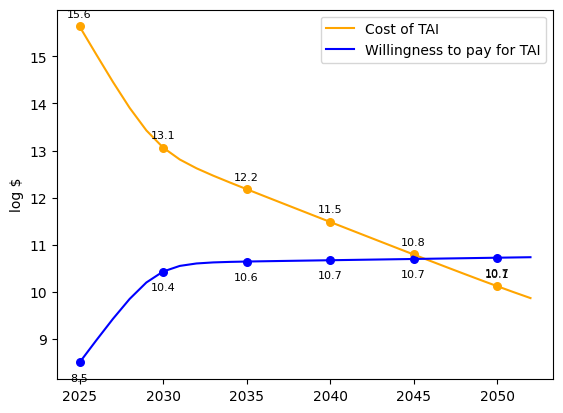

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~158.2 million).
* This doubles every 0.7 year to a max of 0.35138% of GDP (initially ~87.8 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.2 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 26.6 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 10 yea

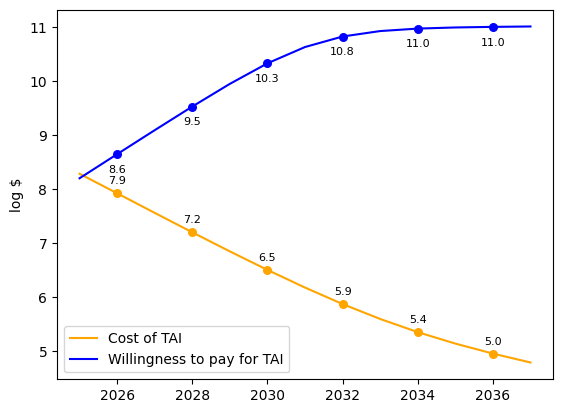

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 41.7 log FLOP (~501.2 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~623.7 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10.2 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~349.9 million).
* This doubles every 0.8 year to a max of 0.011463% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 41.7 logFLOP which costs 23.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 41.5 logFLOP which costs 23.6 log 2025$USD to buy vs. WTP at 8.8 (buys 26.7 log FLOP or 26.9 2025-log-eFLOP)
2027 - TAI takes 41.3 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 41.1 logFLOP 

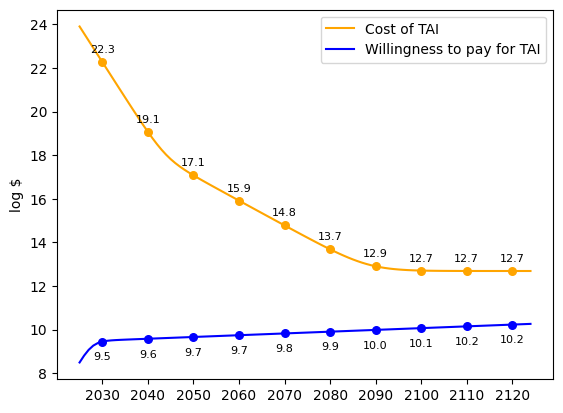

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 52.1 log FLOP (~12.6 quintillion decillion) for transformative capabilities.
* Every 0.2 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.2 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 0.6 year to a max of 0.057802% of GDP (initially ~14.5 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 52.1 logFLOP which costs 33.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 50.8 logFLOP which costs 32.0 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 29.5 2025-log-eFLOP)
2027 - TAI takes 49.6 logFLOP which costs 30.7 log 2025$USD to buy vs. WTP at 9.8 (buys 28.7 log FLOP or 31.2 2025-log-eFLOP)
2028 - TAI takes 48.3 logFLOP w

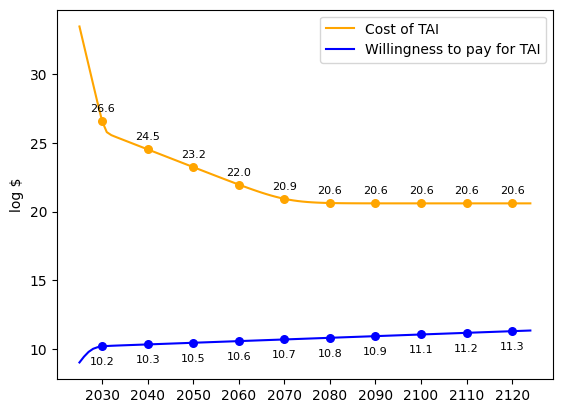

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 3.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~920.9 million).
* This doubles every 1.0 year to a max of 0.004786% of GDP (initially ~1.2 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 8.7 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 29.0 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 28.9 logFLOP which cost

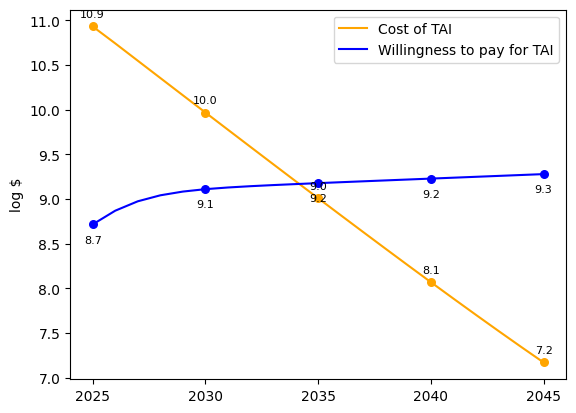

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 33.8 log FLOP (~6.3 decillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.7 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~163.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~365.3 million).
* This doubles every 1.2 year to a max of 0.017679% of GDP (initially ~4.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 33.8 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which costs

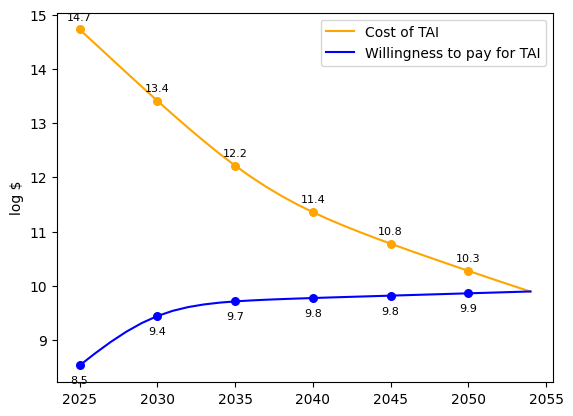

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 42.0 log FLOP (~1.0 billion decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.4 billion).
* This doubles every 1.1 year to a max of 0.049462% of GDP (initially ~12.4 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 42.0 logFLOP which costs 23.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 41.5 logFLOP which costs 23.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 40.9 logFLOP which costs 22.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 40.4 logFLOP which

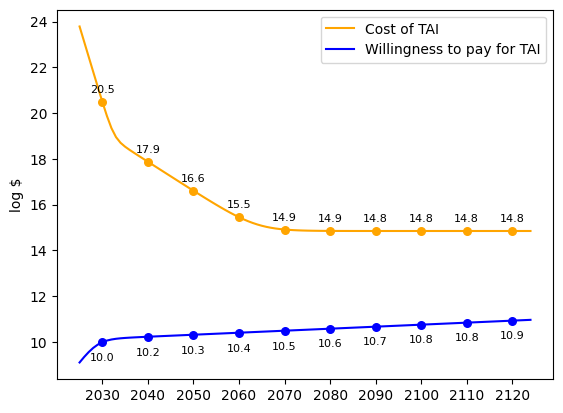

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 41.3 log FLOP (~199.5 million decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~141.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.3 billion).
* This doubles every 1.5 year to a max of 0.02733% of GDP (initially ~6.8 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 41.3 logFLOP which costs 23.2 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 41.0 logFLOP which costs 22.8 log 2025$USD to buy vs. WTP at 9.5 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 40.7 logFLOP which costs 22.4 log 2025$USD to buy vs. WTP at 9.6 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 40.4 logFLOP whic

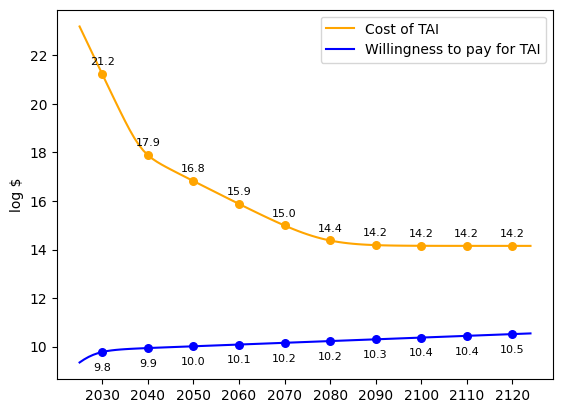

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~36.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~307.8 million).
* This doubles every 0.9 year to a max of 0.045567% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 28.5 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 28.3 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 28.2 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 28.0 logFLOP which costs

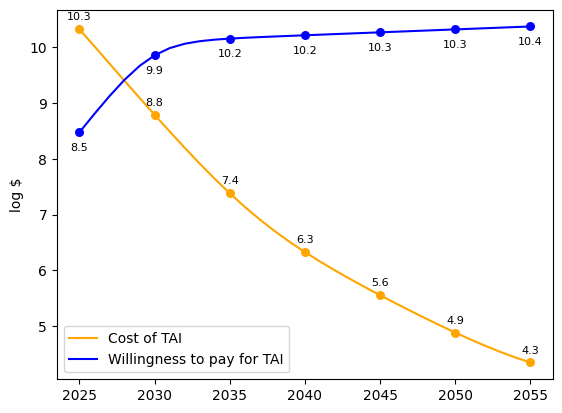

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 25.7 log FLOP (~54.4 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.8 billion).
* This doubles every 1.1 year to a max of 0.023273% of GDP (initially ~5.9 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 9.5 (buys 27.7 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 33.2 logFLOP which costs 1

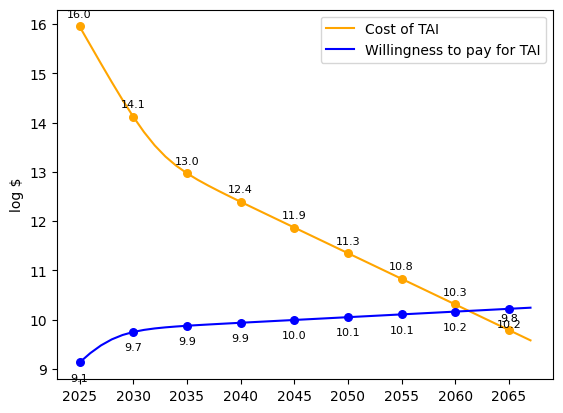

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.6 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 0.4 year to a max of 0.042037% of GDP (initially ~10.6 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 years

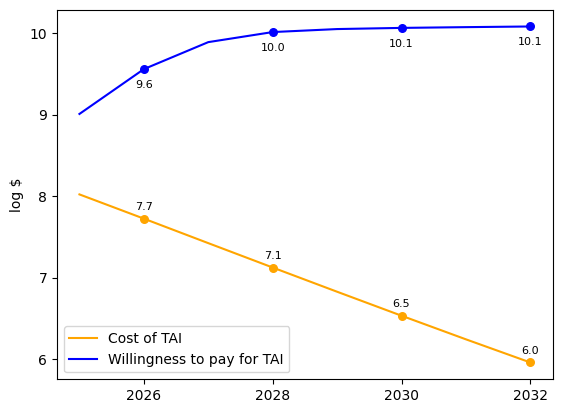

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 24.6 log FLOP (~4.0 septillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~394.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~461.2 million).
* This doubles every 0.9 year to a max of 0.023198% of GDP (initially ~5.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 24.6 logFLOP which costs 6.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 6 year

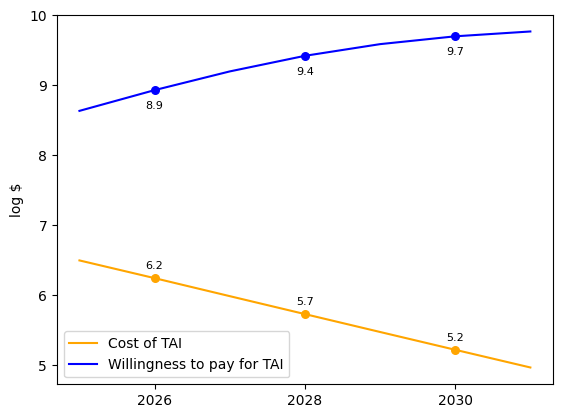

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 31.2 log FLOP (~15.8 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.5 log FLOP (~292.5 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 20.6 log FLOP (~388.6 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~308.2 million).
* This doubles every 0.8 year to a max of 0.005447% of GDP (initially ~1.4 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 31.2 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.4 (buys 25.9 log FLOP or 25.9 2025-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 8.7 (buys 26.2 log FLOP or 26.5 2025-log-eFLOP)
2027 - TAI takes 30.7 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 8.9 (buys 26.6 log FLOP or 27.0 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which c

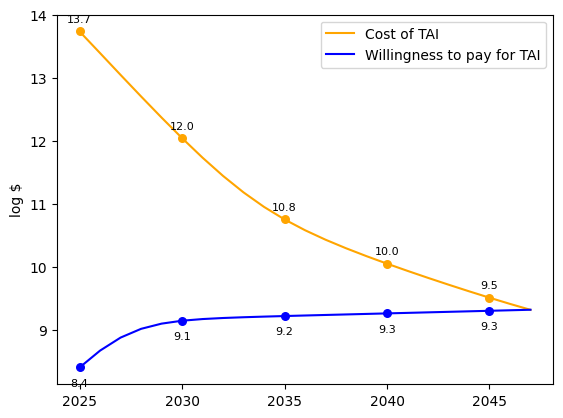

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~448.1 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~195.2 million).
* This doubles every 1.0 year to a max of 0.036323% of GDP (initially ~9.1 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 8.3 (buys 25.9 log FLOP or 25.9 2025-log-eFLOP)
2026 - TAI takes 32.5 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 8.6 (buys 26.3 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.9 (buys 26.7 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 31.8 logFLOP which cost

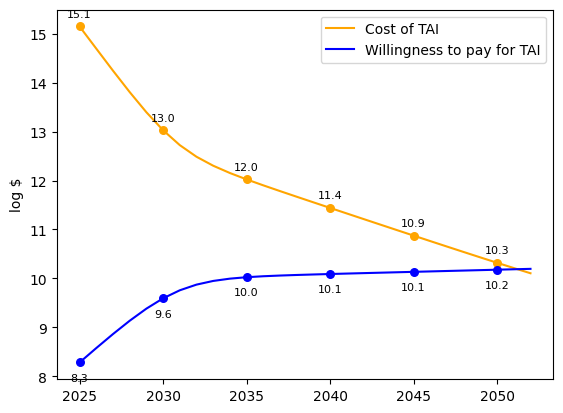

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 36.7 log FLOP (~5.0 thousand decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 26.7 log FLOP (~556.1 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~459.9 million).
* This doubles every 1.2 year to a max of 0.021979% of GDP (initially ~5.6 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 36.7 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 36.5 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 36.3 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 36.1 logFLOP wh

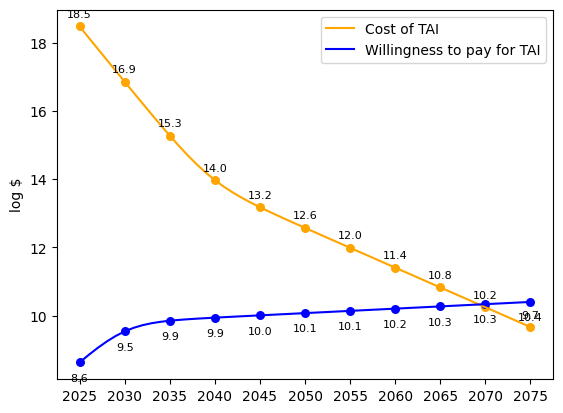

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 33.6 log FLOP (~4.0 decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 28.6 log FLOP (~36.2 octillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~355.1 million).
* This doubles every 2.2 year to a max of 0.013194% of GDP (initially ~3.3 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 33.6 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.4 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 32.0 logFLOP which costs 1

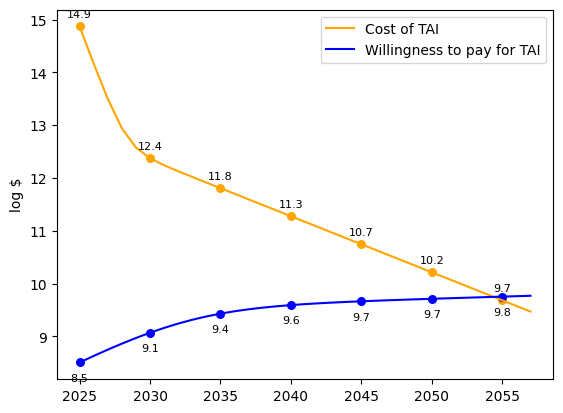

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~813.7 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~307.8 million).
* This doubles every 0.7 year to a max of 0.046031% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 32.5 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 32.2 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which c

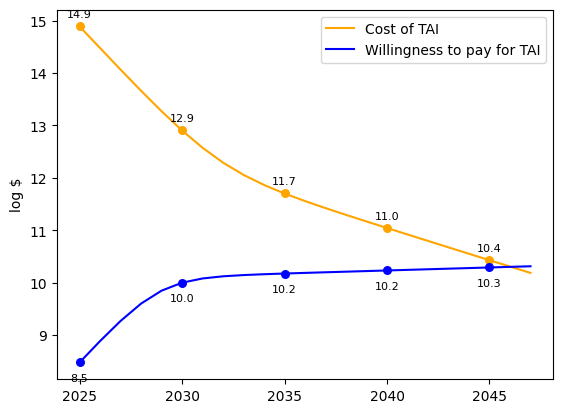

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~476.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~189.7 million).
* This doubles every 1.7 year to a max of 0.015418% of GDP (initially ~3.9 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 25.8 logFLOP which costs 7.4 log 2025$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 yea

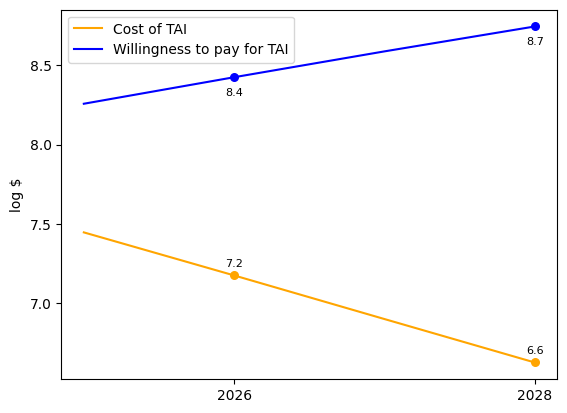

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 30.5 log FLOP (~3.2 nonillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~550.7 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~151.1 quintillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~783.3 million).
* This doubles every 1.3 year to a max of 0.224438% of GDP (initially ~56.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 30.5 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.9 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 30.2 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 29.9 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 29.6 logFLOP which c

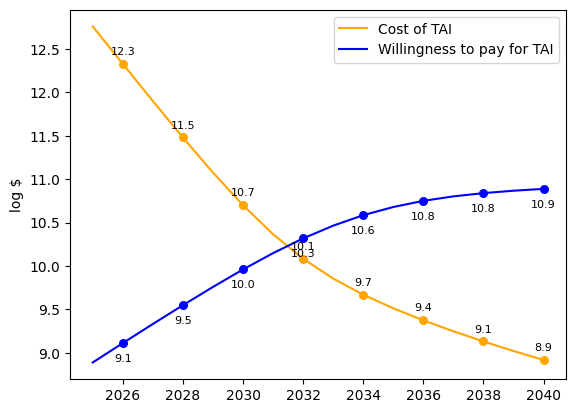

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 40.3 log FLOP (~20.0 million decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~766.9 quadrillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~249.2 million).
* This doubles every 0.7 year to a max of 0.125772% of GDP (initially ~31.7 billion 2025$USD).
* GDP grows at a rate of 1.007x per year.
---
2025 - TAI takes 40.3 logFLOP which costs 22.4 log 2025$USD to buy vs. WTP at 8.4 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 39.9 logFLOP which costs 21.9 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 39.5 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.4 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 39.2 logFLOP w

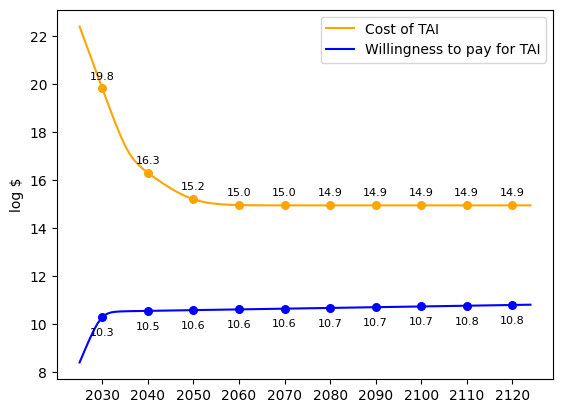

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 42.2 log FLOP (~1.6 billion decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~14.1 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~427.0 million).
* This doubles every 0.6 year to a max of 0.011436% of GDP (initially ~2.9 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 42.2 logFLOP which costs 24.1 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 23.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 41.6 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 41.3 logFLOP whic

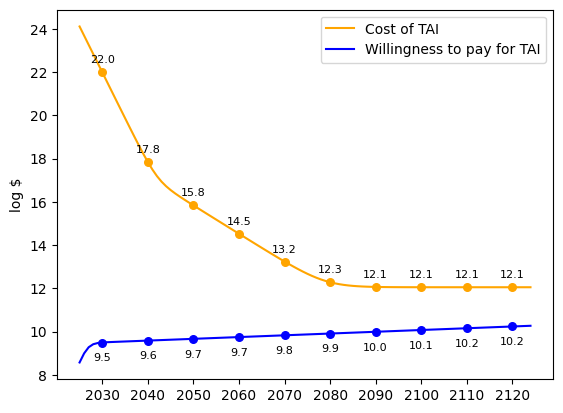

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 3.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~274.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~314.7 million).
* This doubles every 1.3 year to a max of 0.256665% of GDP (initially ~64.2 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 28.1 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 28.0 logFLOP which costs 

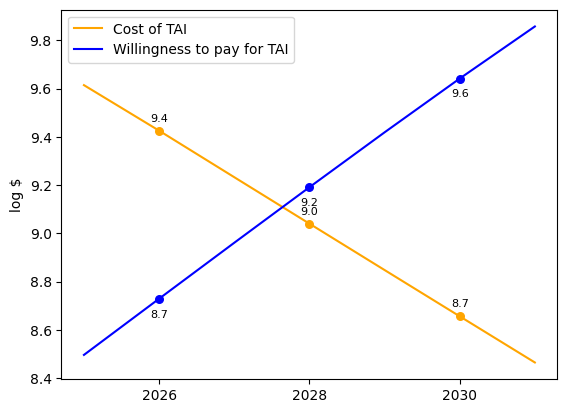

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 38.9 log FLOP (~794.3 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~2.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~393.2 million).
* This doubles every 0.8 year to a max of 0.126341% of GDP (initially ~31.9 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 38.9 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 38.6 logFLOP which costs 19.4 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 38.4 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.7 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 38.1 logFLOP 

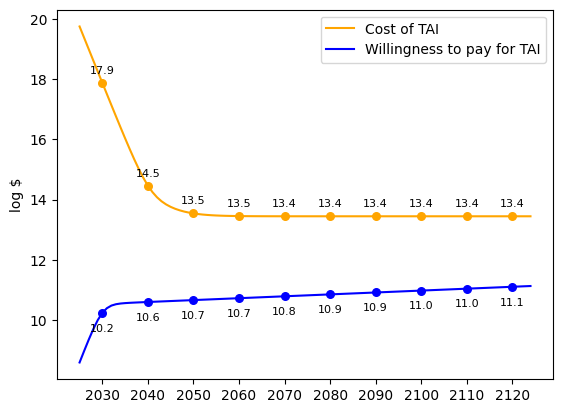

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~555.5 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.6 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~237.1 million).
* This doubles every 1.3 year to a max of 0.016686% of GDP (initially ~4.2 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.4 (buys 26.1 log FLOP or 26.1 2025-log-eFLOP)
2026 - TAI takes 25.8 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.6 (buys 26.4 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 9 yea

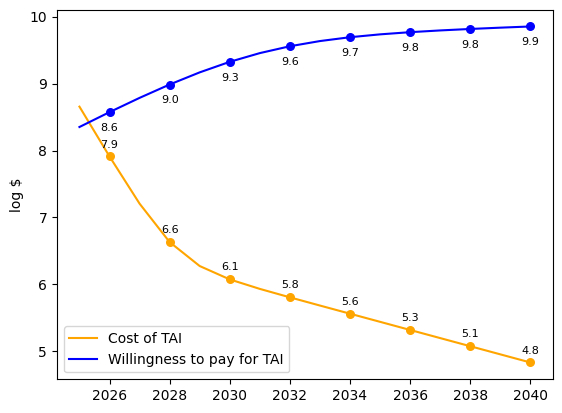

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 40.0 log FLOP (~10.0 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~114.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.1 year to a max of 0.224645% of GDP (initially ~56.2 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 40.0 logFLOP which costs 21.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 39.8 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 39.6 logFLOP which costs 21.1 log 2025$USD to buy vs. WTP at 9.7 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 39.4 logFLOP whi

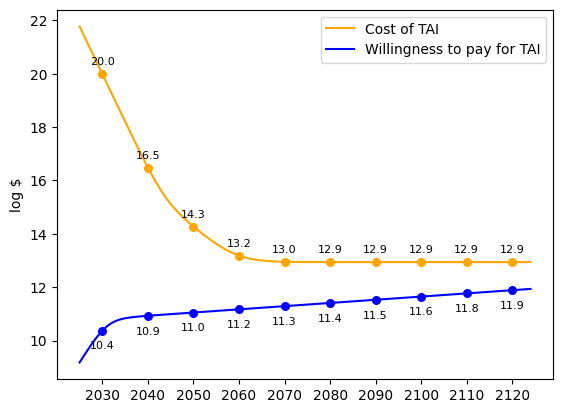

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.8 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 20.2 log FLOP (~151.0 quintillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.2 year to a max of 0.020754% of GDP (initially ~5.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 mor

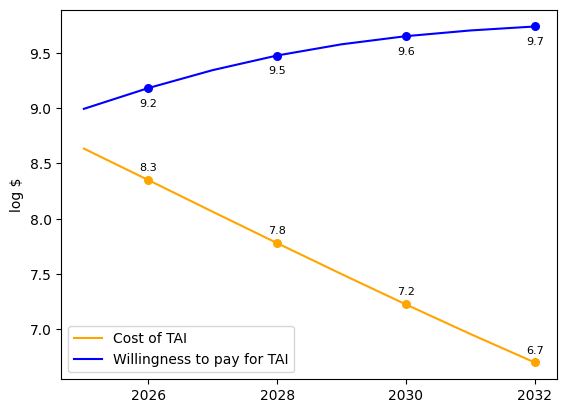

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-07-24 14:44:43.529129
